## Multi-output Variational Sparse Gaussian Processes

We consider the the following model:

$$
f_i(\cdot) \sim \mathrm{GP}(0, \mathsf{K}(\cdot, \cdot)), \qquad i=1,\ldots,N\\
y_i(\cdot) \sim \mathcal{N}(f_i(\cdot), \sigma^2)
$$

This simplest multi-output GP model is essentially N independent GPs, sharing the same kernel and observation noise model. We would like to perform variational inference on this model. Pyro already has a module that implement variational sparse Gaussian process (VSGP).

In [1]:
%matplotlib inline

import torch
import pyro
from pyro.contrib.gp.models.vsgp import VariationalSparseGP
from pyro.contrib.gp.kernels import RBF, Linear, Constant, Sum
from pyro.contrib.gp.likelihoods import Gaussian

import matplotlib.pylab as plt

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [5]:
device = torch.device("cuda")
dtype = torch.float

# generate test data
n_samples = 10000
y_dim = 3
X = 2.0 * torch.randn(n_samples, device=device, dtype=dtype)
a = 5.0 * torch.randn((y_dim,), device=device, dtype=dtype)
b = 3.0 * torch.randn((y_dim,), device=device, dtype=dtype)
n = 0.2 * torch.randn((y_dim, n_samples), device=device, dtype=dtype)
y = torch.sin(a.unsqueeze(-1) * X + b.unsqueeze(-1)) * X + n

# specify the number of inducing points and thei initial positions and values
n_inducing = 50
stride = int(n_samples / n_inducing)
Xu = torch.linspace(
    X.min(), X.max(), steps=n_inducing, device=device, dtype=dtype)  # initial value
u = torch.zeros(y_dim, n_inducing, device=device, dtype=dtype)  # initial value

Let us visualize input data. The inducing points are shown in black.

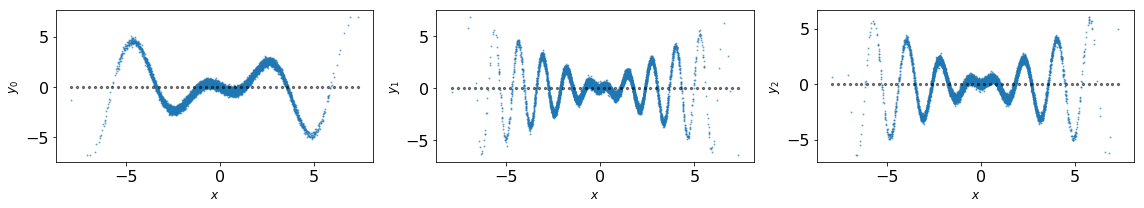

In [6]:
fig, axs = plt.subplots(ncols=y_dim, figsize=(16, y_dim))
if y_dim == 1:
    axs = [axs]
for i, ax in enumerate(axs):
    ax.scatter(X.cpu().numpy(), y[i, :].cpu().numpy(), s=1, alpha=0.5)
    ax.scatter(Xu.cpu().numpy(), u[i, :].cpu().numpy(), s=5, alpha=0.5, color='black')
    ax.set_xlabel('$x$', fontsize=12)
    ax.set_ylabel(f'$y_{i}$', fontsize=12)
    
plt.tight_layout()

In [7]:
# define the kernel
kernel_rbf = RBF(
    input_dim=1,
    variance=torch.tensor(0.1, device=device, dtype=dtype),
    lengthscale=torch.tensor(0.1, device=device, dtype=dtype))
kernel_linear = Linear(
    input_dim=y_dim,
    variance=torch.tensor(0.1, device=device, dtype=dtype))
kernel_constant = Constant(
    input_dim=y_dim,
    variance=torch.tensor(0.1, device=device, dtype=dtype))
kernel = Sum(kernel_rbf, Sum(kernel_linear, kernel_constant))

# define the likelihood
likelihood = Gaussian(variance=torch.tensor(0.1, device=device, dtype=dtype))

# define the model
gp_model = VariationalSparseGP(
    X=X,
    y=y,
    kernel=kernel,
    Xu=Xu,
    likelihood=likelihood,
    jitter=1e-5)

A basic training loop using full data (i.e. no minibatching)

iteration: 0, loss: 70266.734375
iteration: 100, loss: 23891.4375
iteration: 200, loss: 9866.888671875
iteration: 300, loss: 1793.7493896484375
iteration: 400, loss: -1741.5091552734375
iteration: 500, loss: -3382.103515625
iteration: 600, loss: -3980.635009765625
iteration: 700, loss: -4426.9453125
iteration: 800, loss: -4758.01318359375
iteration: 900, loss: -5010.2734375
iteration: 1000, loss: -5236.29931640625
iteration: 1100, loss: -5328.49072265625
iteration: 1200, loss: -5417.6865234375
iteration: 1300, loss: -5453.89599609375
iteration: 1400, loss: -5484.9111328125
iteration: 1500, loss: -5478.87109375
iteration: 1600, loss: -5493.22900390625
iteration: 1700, loss: -5509.900390625
iteration: 1800, loss: -5522.79345703125
iteration: 1900, loss: -5521.55517578125


Text(0, 0.5, 'loss')

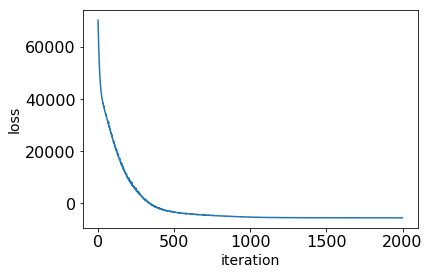

In [8]:
num_steps = 2000
lr = 1e-2

optimizer = torch.optim.Adam(gp_model.parameters(), lr=lr)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

losses = []
for i in range(num_steps):
    optimizer.zero_grad()
    gp_model.set_data(X, y)
    loss = loss_fn(gp_model.model, gp_model.guide)
    if i % 100 == 0:
        print(f'iteration: {i}, loss: {loss.item()}')
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('loss', fontsize=14)

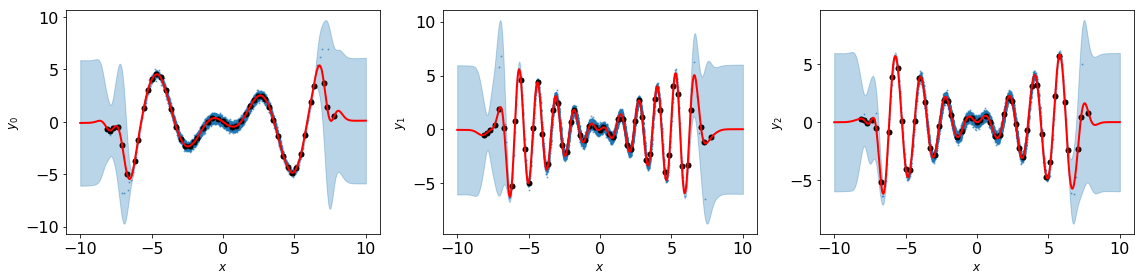

In [10]:
n_test = 500
Xtest = torch.linspace(-10, 10, n_test).to(device)  # test inputs

with torch.no_grad():
    mean, cov = gp_model(Xtest, full_cov=False)    
sd = cov.sqrt()  # standard deviation at each input point x

fig, axs = plt.subplots(ncols=y_dim, figsize=(16, 4))
if y_dim == 1:
    axs = [axs]
for i, ax in enumerate(axs):
    ax.scatter(X.cpu().numpy(), y[i, :].cpu().numpy(), s=1, alpha=0.5)
    
    ax.plot(Xtest.cpu().numpy(), mean[i, :].cpu().numpy(), 'r', lw=2)  # plot the mean
    ax.fill_between(Xtest.cpu().numpy(),  # plot the two-sigma uncertainty about the mean
                     (mean[i, :] - 2.0 * sd[i, :]).cpu().numpy(),
                     (mean[i, :] + 2.0 * sd[i, :]).cpu().numpy(),
                     color='C0', alpha=0.3)
    
    ax.scatter(gp_model.Xu.detach().cpu().numpy(),
               gp_model.u_loc[i, :].detach().cpu().numpy(),
               marker='.', s=100, color='black')
    ax.set_xlabel('$x$', fontsize=12)
    ax.set_ylabel(f'$y_{i}$', fontsize=12)
    
plt.tight_layout()

Notice the x and y position of the trained inducing points (shown in black).

**Bonus:**

- What happens when you train N independent GPs with N independent kernels? (try it!)
- What happens when you add more inducing points? how many inducing points is enough?
- Try different kernels and try to get an intuition about what kind of feature each kernel adds to the function space.